In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nb_cells = 10
r_in = 110
r_out = 150

In [3]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

In [4]:
def rendering_results(x_data, y_data, title, xlabel, ylabel, legend, data_dot='.'):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    fig, ax = plt.subplots()
    plt.plot(x_data, y_data, data_dot, markersize=10, alpha=0.4)
    plt.plot(x_data, intercept+slope*np.array(x_data), '-')
    plt.title(title, fontdict={'fontsize': 32})
    plt.legend(legend, loc='upper left', fontsize=16)
    plt.xlabel(xlabel, fontdict={'fontsize': 24})
    plt.ylabel(ylabel, fontdict={'fontsize': 24})
    fig.set_size_inches(12, 12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    std = np.sum(np.power(intercept+slope*np.array(x_data)-y_data, 2))
    print('R value :', r_value,
          '\nStandard error :', (std/sym_organo.Ne)**0.5)

In [5]:
def rendering_convergence_results(x_data, y_data, title, xlabel, ylabel, legend, data_dot='-', rol_win=50):
    fig, ax = plt.subplots()
    plt.plot(x_data, y_data, data_dot, markersize=10, alpha=0.4)
    rolling = y_data.rolling(rol_win, min_periods=0, center=True).mean()
    plt.plot(x_data, rolling, data_dot, markersize=20, alpha=1)
    plt.title(title, fontdict={'fontsize': 32})
    plt.legend(legend, loc='upper left', fontsize=16)
    plt.xlabel(xlabel, fontdict={'fontsize': 24})
    plt.ylabel(ylabel, fontdict={'fontsize': 24})
    fig.set_size_inches(12, 12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Symetric case

In [6]:
sym_organo = generate_ring(nb_cells, r_in, r_out)
Nf= sym_organo.Nf
geom.update_all(sym_organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(sym_organo.settings['R_out']-sym_organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*sym_organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': sym_organo.settings['lumen_volume'],
        'lumen_volume': sym_organo.settings['lumen_volume']
        }
    }

sym_organo.update_specs(specs, reset=True)
sym_organo.edge_df.loc[:nb_cells, 'line_tension'] *= 2
sym_organo.edge_df.loc[nb_cells:2*nb_cells, 'line_tension'] = 0
normalize_scale(sym_organo, geom, refer='edges')
geom.update_all(sym_organo)


Reseting datasets values with new specs


In [7]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*sym_organo.Nf),[1000]*(3*sym_organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

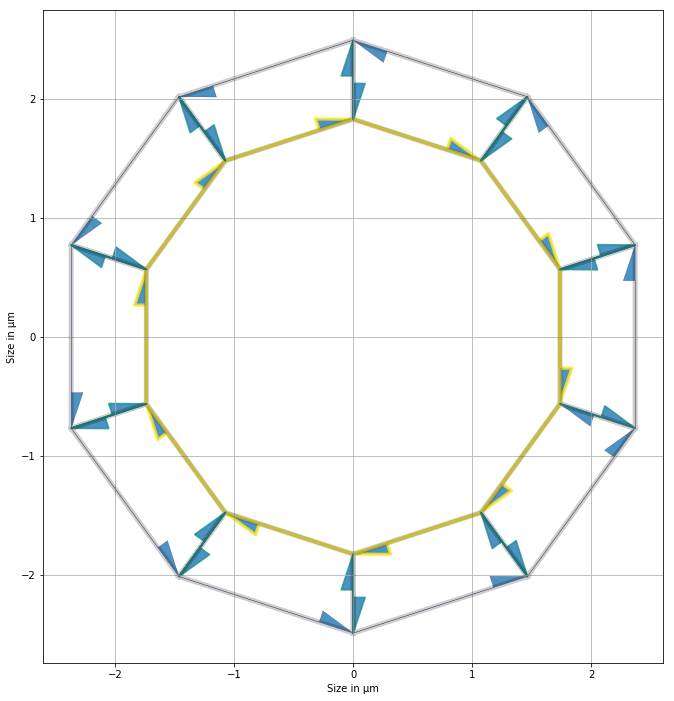

In [8]:
print_tensions(sym_organo, sym_organo)

## Force inference

Solving time: 4.425815
Distance from th organo to exp organo : 8.365521252793599
Distance from th tensions to exp tensions : 6.694182332335604


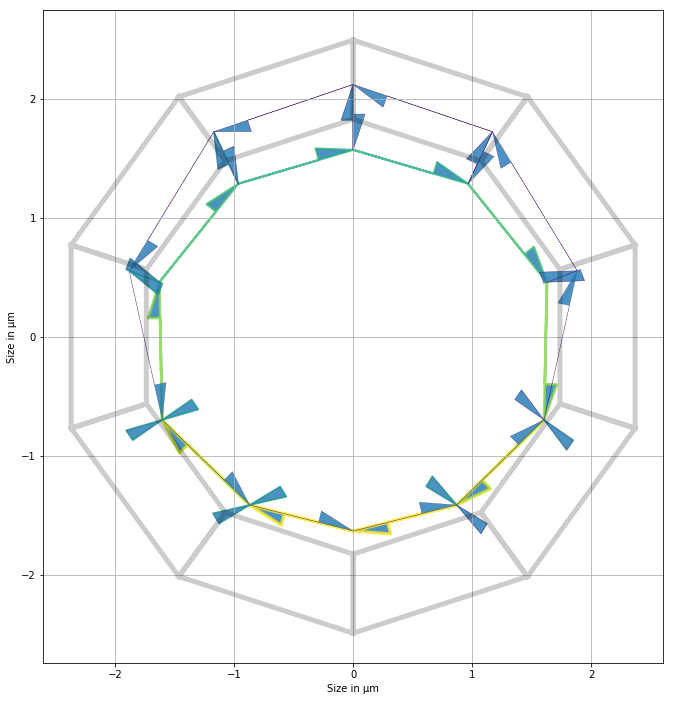

In [9]:
initial_guess = infer_forces(sym_organo, 'NNLS', sup_param='')
start = time.clock()
tensions_sym_organo = sym_organo.copy()
tensions_sym_organo.edge_df.line_tension = prepare_tensions(tensions_sym_organo,
                                                            initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(tensions_sym_organo, False))
Solver.find_energy_min(tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(tensions_sym_organo, False))
print_tensions(tensions_sym_organo, sym_organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

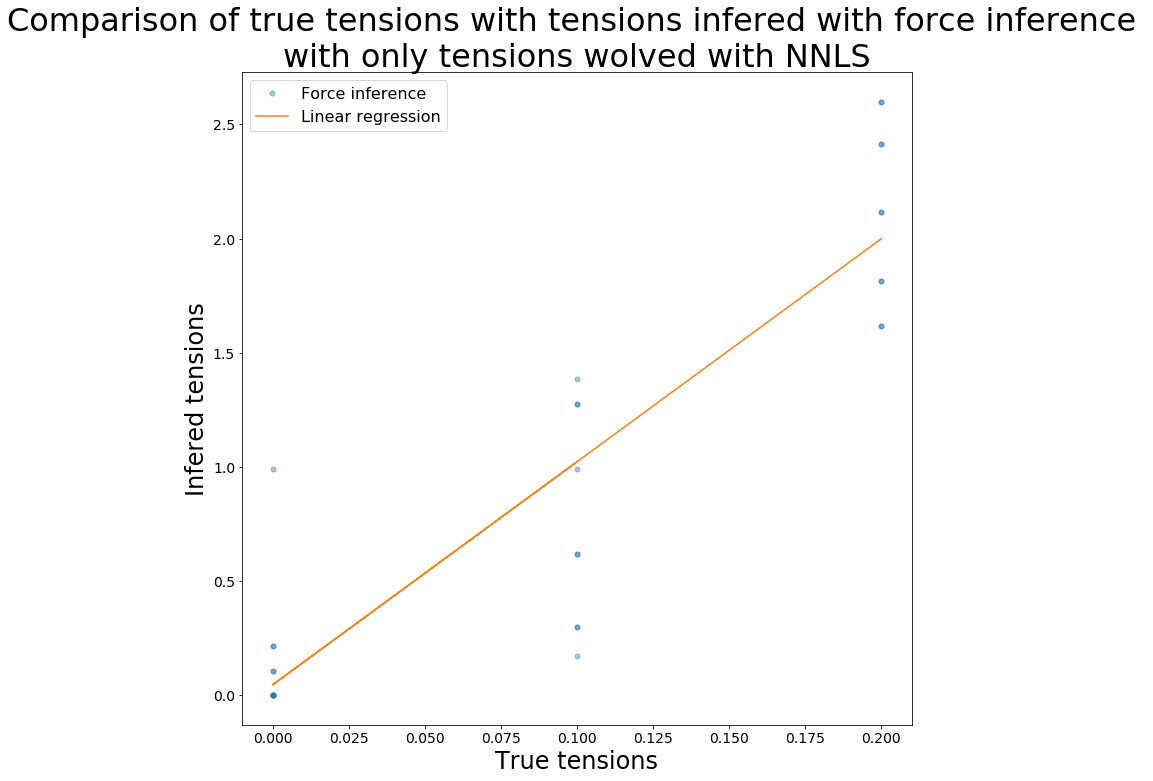

R value : 0.8984233000147915 
Standard error : 0.3456938669729891


In [10]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  initial_guess['tensions'],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Scale factor optimization

iter   time      nfev    incumbent   f(incumbent)
   1   52.15      10      0.00000     0.00545
   2   55.49      15      0.00000     0.00545
   3   59.19      20      0.00000     0.00545
   4   59.79      25      0.00100     0.00313
Brut force search summary
              solving time: 59.79185605049133
              nb iter: 4
              nfev: 25
              x_ub: 0.001
              ub: 0.0031317970905181233
Optimization terminated successfully.
         Current function value: 0.003054
         Iterations: 1
         Function evaluations: 2
Solving time: 60.17115999999999


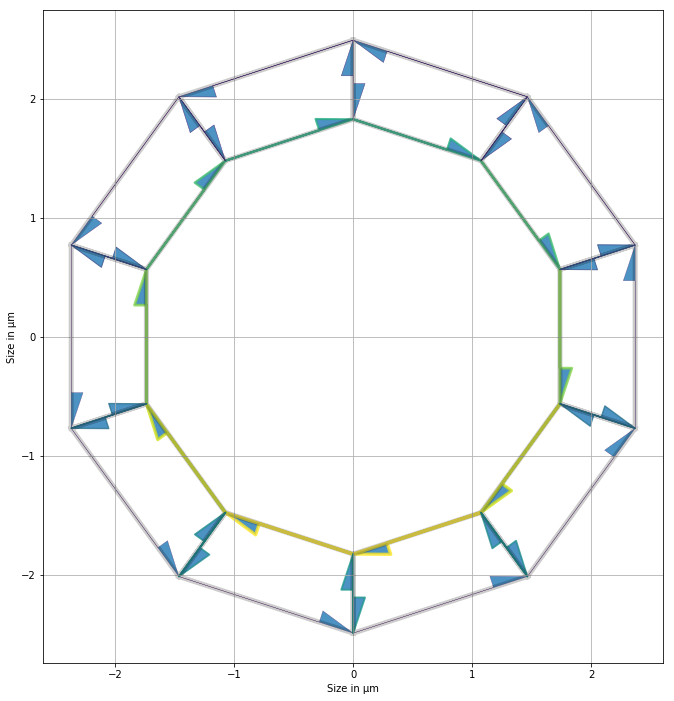

In [11]:
initial_guess = infer_forces(sym_organo, 'NNLS', sup_param='')
start = time.clock()
rescaled_tensions_sym_organo = sym_organo.copy()
opt_scale = adjust_scale(sym_organo,
                         initial_guess['tensions'],
                         verbose=2,
                         **nm_opt)
rescaled_tensions_sym_organo.edge_df.line_tension = prepare_tensions(rescaled_tensions_sym_organo,
                                                                     opt_scale.x*initial_guess['tensions'])
Solver.find_energy_min(rescaled_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_tensions_sym_organo, sym_organo)

In [12]:
dist_init_point = np.sum(np.linalg.norm(_distance(tensions_sym_organo, rescaled_tensions_sym_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(sym_organo, rescaled_tensions_sym_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                             tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                         rescaled_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th sym_organo to exp sym_organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 8.365135219236691
Distance from th sym_organo to exp sym_organo at optima: 0.0030536438951543313
Distance from th tensions to exp tensions at initial point : 6.694182332335604
Distance from th tensions to exp tensions at initial point : 0.6926275600584159


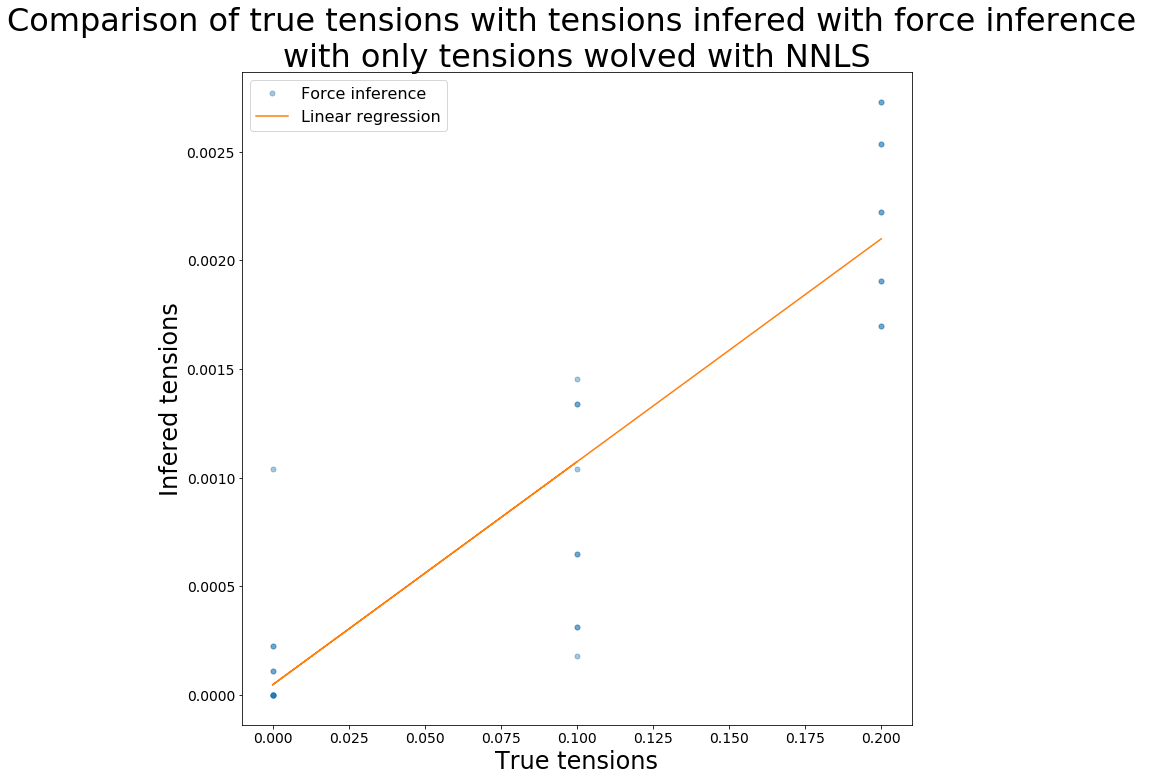

R value : 0.8984233000147918 
Standard error : 0.0003629785603216386


In [13]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  rescaled_tensions_sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Distance minimization

`xtol` termination condition is satisfied.
Function evaluations 941, initial cost 2.8855e-07, final cost 7.5131e-16, first-order optimality 1.98e-12.
Solving time: 155.309736
Distance from th sym_organo to exp sym_organo : 0.0
Distance from th tensions to exp tensions : 0.6932654237617247


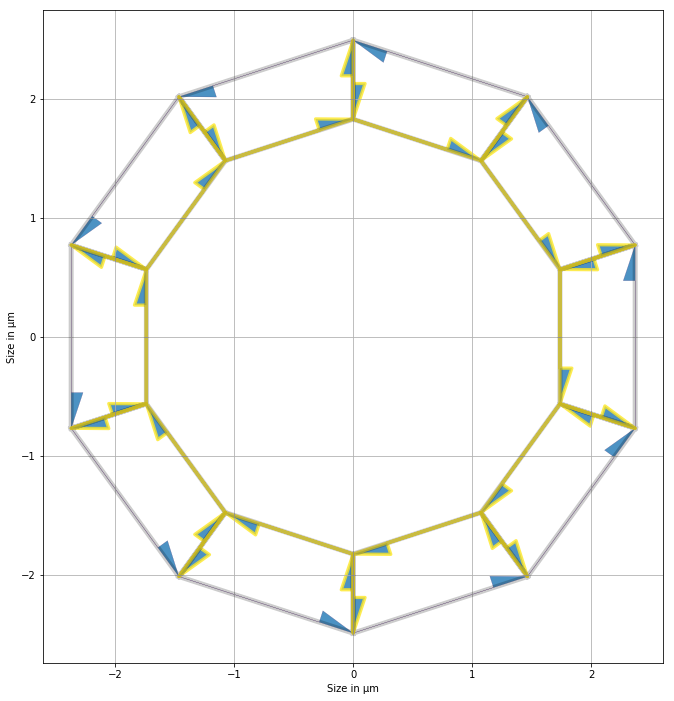

In [14]:
iprint_file = "../../assets/dist_at_each_f_ev/sym_only_tensions.txt"
res_sym_tensions = adjust_tensions(sym_organo, opt_scale.x*initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_tensions_sym_organo = sym_organo.copy()
opt_tensions_sym_organo.edge_df.line_tension = prepare_tensions(opt_tensions_sym_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, opt_tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                opt_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))))

In [15]:
dist_init_point = np.sum(np.linalg.norm(_distance(rescaled_tensions_sym_organo, opt_tensions_sym_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(opt_tensions_sym_organo, opt_tensions_sym_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                             rescaled_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                         opt_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th sym_organo to exp sym_organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 0.0030536438951543313
Distance from th sym_organo to exp sym_organo at optima: 0.0
Distance from th tensions to exp tensions at initial point : 0.6926275600584159
Distance from th tensions to exp tensions at initial point : 0.6932654237617247


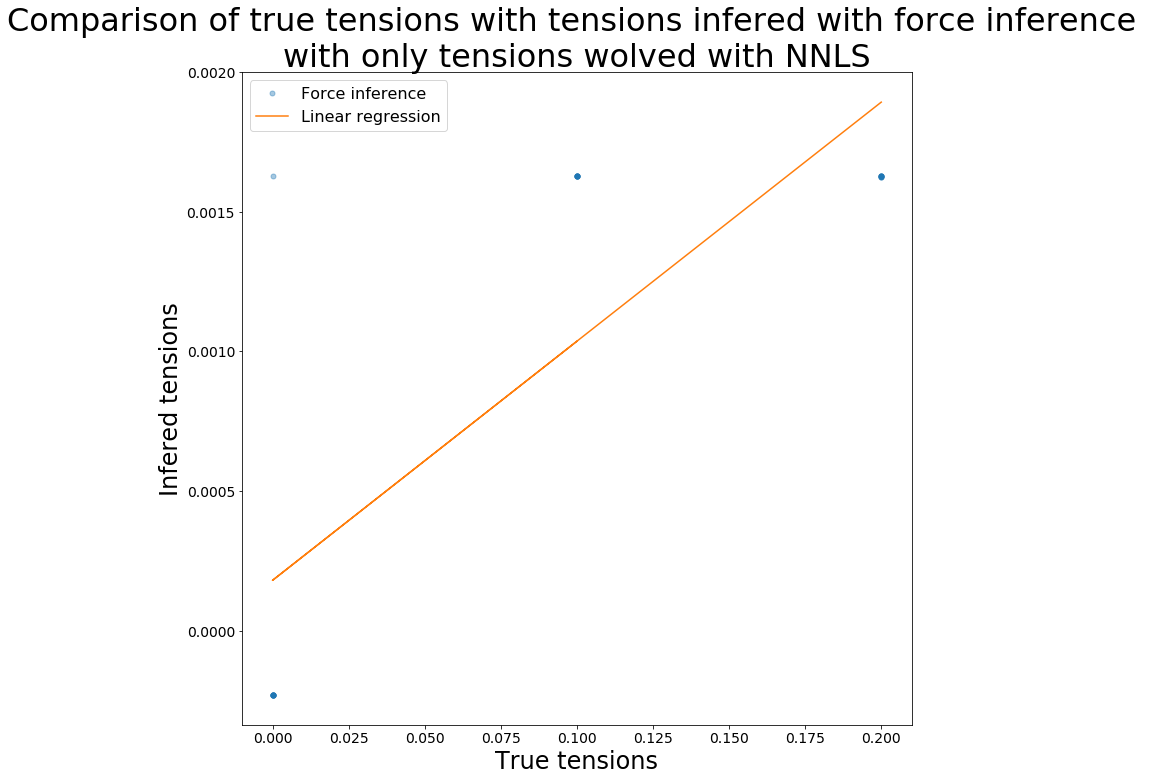

R value : 0.8175128314427312 
Standard error : 0.00043676029270436456


In [16]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  opt_tensions_sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

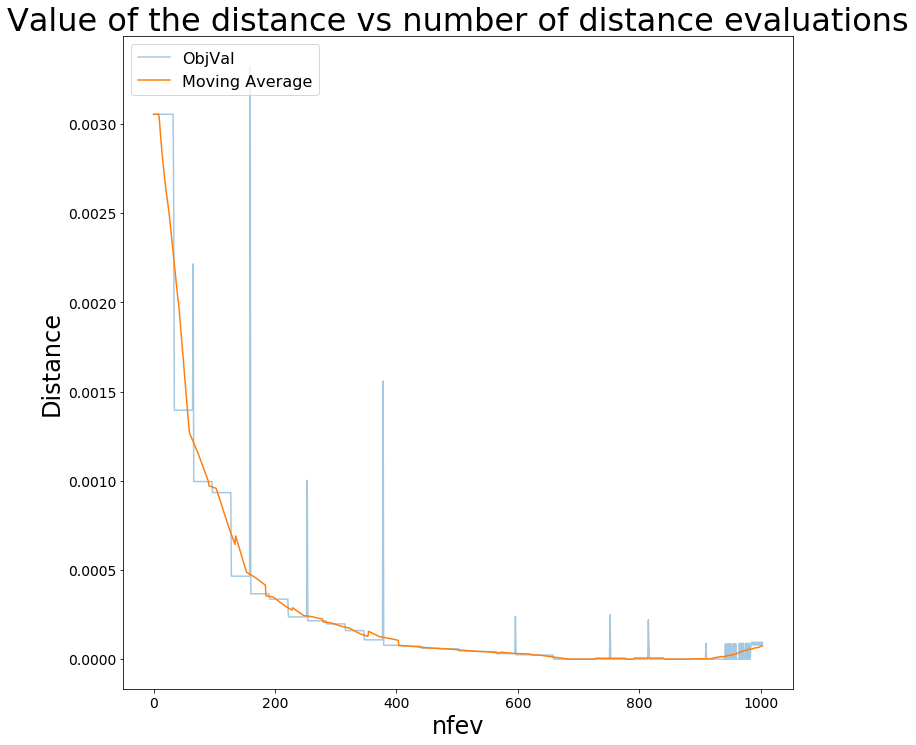

In [17]:
iter_data = pd.read_csv(iprint_file, header=None)
rendering_convergence_results(np.arange(len(iter_data[0])),
                              iter_data[0],
                              'Value of the distance vs number of distance evaluations',
                              'nfev', 'Distance', ('ObjVal', 'Moving Average'),
                              data_dot='-', rol_win=50)